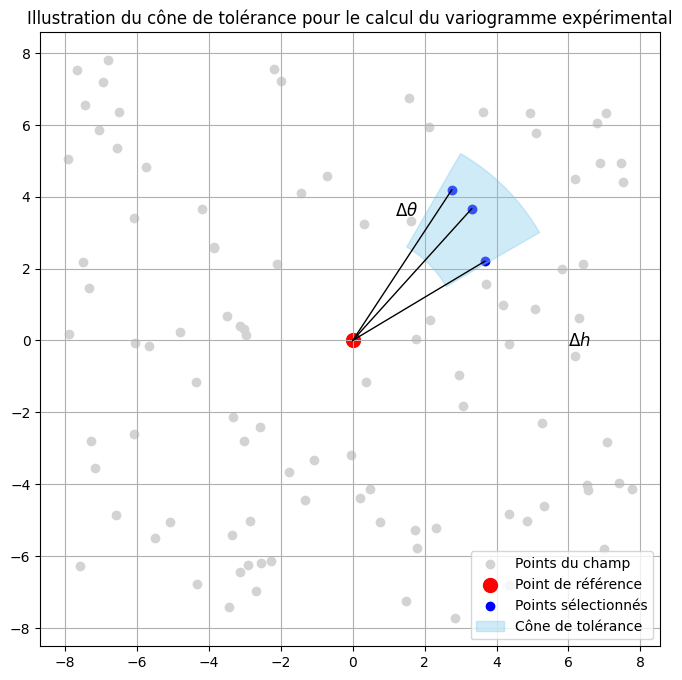

In [3]:
import matplotlib.pyplot as plt
import numpy as np

# Parameters
center = np.array([0, 0])  # Point rouge
direction_angle = np.deg2rad(45)  # Direction centrale du cône (en radians)
delta_theta = np.deg2rad(30)  # Ouverture angulaire totale (±15°)
h_min = 3
h_max = 6
num_points = 100

# Générer un champ de points aléatoires
np.random.seed(42)
points = np.random.uniform(-8, 8, size=(num_points, 2))

# Fonction pour vérifier si un point est dans le cône de tolérance
def in_tolerance_cone(p, center, direction_angle, delta_theta, h_min, h_max):
    vec = p - center
    dist = np.linalg.norm(vec)
    if dist < h_min or dist > h_max:
        return False
    angle = np.arctan2(vec[1], vec[0])
    angle_diff = np.abs((angle - direction_angle + np.pi) % (2 * np.pi) - np.pi)
    return angle_diff <= delta_theta / 2

# Sélectionner les points dans le cône
selected_points = np.array([p for p in points if in_tolerance_cone(p, center, direction_angle, delta_theta, h_min, h_max)])

# Tracer
fig, ax = plt.subplots(figsize=(8, 8))
ax.scatter(points[:, 0], points[:, 1], color='lightgray', label='Points du champ')
ax.scatter(center[0], center[1], color='red', s=100, label='Point de référence')
ax.scatter(selected_points[:, 0], selected_points[:, 1], color='blue', label='Points sélectionnés')

# Relier les points sélectionnés au point rouge
for p in selected_points:
    ax.plot([center[0], p[0]], [center[1], p[1]], color='black', linewidth=1)

# Dessiner le cône de tolérance en bleu pâle
cone_angles = np.linspace(direction_angle - delta_theta / 2, direction_angle + delta_theta / 2, 100)
arc_outer = np.array([[h_max * np.cos(a), h_max * np.sin(a)] for a in cone_angles])
arc_inner = np.array([[h_min * np.cos(a), h_min * np.sin(a)] for a in cone_angles[::-1]])
cone_polygon = np.vstack((arc_outer, arc_inner))

ax.fill(cone_polygon[:, 0], cone_polygon[:, 1], color='skyblue', alpha=0.4, label='Cône de tolérance')

# Ajouter les annotations
ax.text(h_max, 0, r'$\Delta h$', fontsize=12, color='black', ha='left', va='center')
ax.text(1.5, h_max * 0.6, r'$\Delta \theta$', fontsize=12, color='black', ha='center', va='center')

ax.set_aspect('equal')
ax.set_title("Illustration du cône de tolérance pour le calcul du variogramme expérimental")
ax.legend()
plt.grid(True)
plt.savefig("cone_de_tolerance.png")
plt.show()



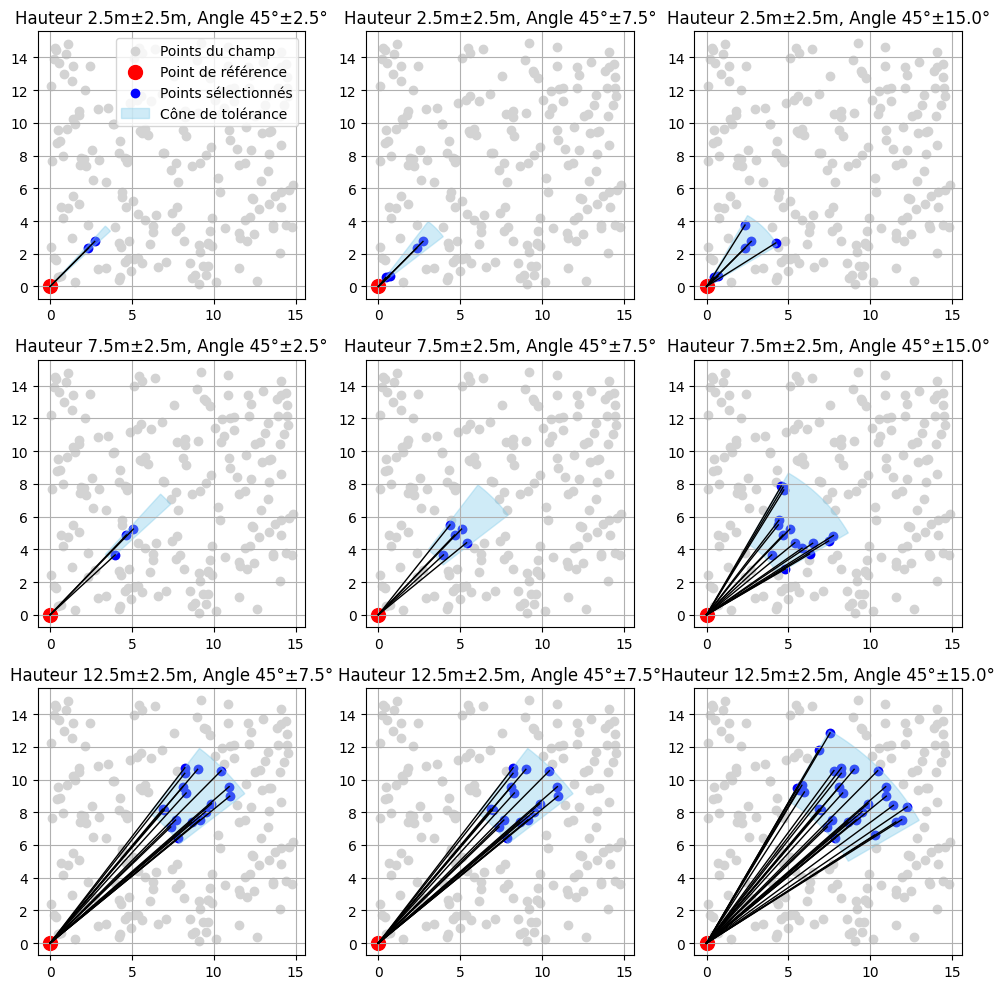

In [47]:
import matplotlib.pyplot as plt
import numpy as np

# Fonction pour vérifier si un point est dans le cône de tolérance
def in_tolerance_cone(p, center, direction_angle, delta_theta, h_min, h_max):
    vec = p - center
    dist = np.linalg.norm(vec)
    if dist < h_min or dist > h_max:
        return False
    angle = np.arctan2(vec[1], vec[0])
    angle_diff = np.abs((angle - direction_angle + np.pi) % (2 * np.pi) - np.pi)
    return angle_diff <= delta_theta / 2

# Paramètres de base
center = np.array([0, 0])  # Point rouge
direction_angle = np.deg2rad(45)  # Direction centrale du cône (en radians)
num_points = 200

# Liste des tolérances pour les différentes figures
params = [
    (0, 5, np.deg2rad(5)), 
    (0, 5, np.deg2rad(15)),  
    (0, 5, np.deg2rad(30)),  
    (5, 10, np.deg2rad(5)),  
    (5, 10, np.deg2rad(15)), 
    (5, 10, np.deg2rad(30)),  
    (10, 15, np.deg2rad(15)),  
    (10, 15, np.deg2rad(15)), 
    (10, 15, np.deg2rad(30)),  
]

# Créer les 4 sous-figures côte à côte
fig, axes = plt.subplots(3, 3, figsize=(10, 10))

for idx, (ax, (h_min, h_max, delta_theta)) in enumerate(zip(axes.flatten(), params)):
    # Générer un champ de points aléatoires
    np.random.seed(42)
    points = np.random.uniform(0, 15, size=(num_points, 2))

    # Sélectionner les points dans le cône
    selected_points = np.array([p for p in points if in_tolerance_cone(p, center, direction_angle, delta_theta, h_min, h_max)])

    # Tracer les points
    ax.scatter(points[:, 0], points[:, 1], color='lightgray', label='Points du champ')
    ax.scatter(center[0], center[1], color='red', s=100, label='Point de référence')
    ax.scatter(selected_points[:, 0], selected_points[:, 1], color='blue', label='Points sélectionnés')

    # Relier les points sélectionnés au point rouge
    for p in selected_points:
        ax.plot([center[0], p[0]], [center[1], p[1]], color='black', linewidth=1)

    # Dessiner le cône de tolérance
    cone_angles = np.linspace(direction_angle - delta_theta / 2, direction_angle + delta_theta / 2, 100)
    arc_outer = np.array([[h_max * np.cos(a), h_max * np.sin(a)] for a in cone_angles])
    arc_inner = np.array([[h_min * np.cos(a), h_min * np.sin(a)] for a in cone_angles[::-1]])
    cone_polygon = np.vstack((arc_outer, arc_inner))
    ax.fill(cone_polygon[:, 0], cone_polygon[:, 1], color='skyblue', alpha=0.4, label='Cône de tolérance')

    # Configuration de l'axe
    ax.set_aspect('equal')
    ax.set_title(f"Hauteur {(h_max-h_min)/2+h_min}m±{(h_max-h_min)/2}m, Angle 45°±{np.round(delta_theta*180/np.pi/2,decimals=1)}°")
    ax.grid(True)

    # Ajouter la légende uniquement dans la première figure (index 0)
    if idx == 0:
        ax.legend(loc='upper right')

# Ajuster l'espace entre les subplots
plt.tight_layout()
plt.savefig("C6_tolerance.png")
plt.show()
